# Создание бейзлайна и оценка качества для задачи классификации (Decision Tree)

Импорт необходимых библиотек

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Загрузка данных

In [2]:
df = pd.read_csv('/content/diabetes_dataset.csv')

Удаляем строки с отсутствующей целевой переменной

In [3]:
df = df.dropna(subset=['diabetes'])

Разделяем признаки и целевую переменную

In [4]:
X = df.drop(columns=['diabetes'])
y = df['diabetes']

Определяем категориальные и числовые признаки

In [5]:
categorical_features = ['gender', 'location', 'smoking_history', 'year']
numeric_features = [col for col in X.columns if col not in categorical_features]

Создаём ColumnTransformer:
- OneHotEncoder для категориальных;
- StandardScaler для числовых.

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

Создаём baseline модель Decision Tree

In [7]:
tree_clf = DecisionTreeClassifier(random_state=42)

Pipeline: препроцессинг -> модель

In [8]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree', tree_clf)
])

Разделяем выборку на обучающую и тестовую

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Обучение baseline модели

In [10]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'location',
                                                   'smoking_history', 'year']),
                                                 ('num', StandardScaler(),
                                                  ['age',
                                                   'race:AfricanAmerican',
                                                   'race:Asian',
                                                   'race:Caucasian',
                                                   'race:Hispanic',
                                                   'race:Other', 'hypertension',
                                                   'heart_disease', 'bmi',
                                                   'hbA1c_level',
                                                   'blood_glucose_level'])])),
                ('tree', DecisionTreeClassifier(random_state=42))])

Предсказание на тестовой выборке

In [11]:
y_pred = model.predict(X_test)

Были выбраны следующие метрики качества:
- Accuracy: общая доля верных предсказаний - базовая метрика для классификатора;
- Precision: доля корректно найденных больных среди всех, кому предсказан диабет;
- Recall: доля найденных больных среди всех реальных больных - критично важно в медицине.
- F1-score: гармоническое среднее precision и recall, особенно важно при дисбалансе классов.

### Выводим метрики

In [12]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label=1))
print("Recall:", recall_score(y_test, y_pred, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred, pos_label=1))

Accuracy: 0.9548
Precision: 0.7311265969802555
Recall: 0.7405882352941177
F1-score: 0.7358270017533606


Модель дерева решений показывает высокое общее качество классификации (Accuracy = 0.955), что лишь немного ниже, чем у модели логистической регрессии. Показатель Precision равен 0.731 - это означает, что среди всех пациентов, которым модель предсказывает наличие диабета, около 73% действительно больны. Значение ниже, чем у логистической регрессии, что говорит о большем количестве ложных срабатываний.

Однако Recall модели дерева решений (0.741) заметно выше, чем в предыдущей модели. Это означает, что дерево корректно обнаруживает около 74% больных пациентов. Такой рост Recall важен для медицинских задач, где пропуск больного пациента нежелателен.

F1-score составляет 0.736 и демонстрирует более сбалансированную работу между Precision и Recall по сравнению с логистической регрессией, отражая улучшение способности модели выявлять больных при некотором снижении точности положительных предсказаний.

# Улучшение бейзлайна для DecisionTreeClassifier

### Проверка гипотез

Импорт библиотек

In [13]:
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

Гипотеза 1: Ограничение глубины дерева (max_depth) уменьшит переобучение
и улучшит обобщающую способность модели.

In [14]:
depth_values = [3, 5, 7, 10, None]  # None = без ограничения
cv_scores_depth = []

Препроцессор остаётся прежним

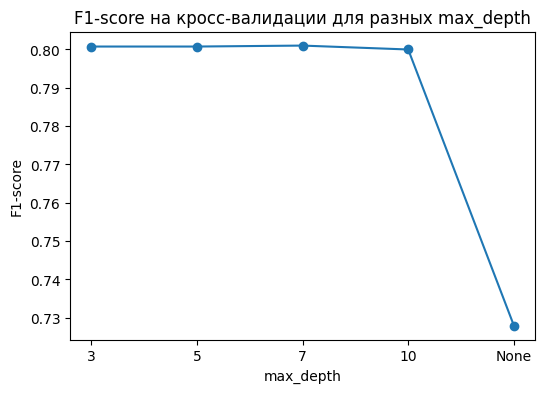

Лучшее значение max_depth: 7


In [15]:
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

for depth in depth_values:
    model_depth = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('tree', DecisionTreeClassifier(max_depth=depth, random_state=42))
    ])
    scores = cross_val_score(model_depth, X_train, y_train, cv=5, scoring='f1')
    cv_scores_depth.append(scores.mean())

plt.figure(figsize=(6,4))
plt.plot([str(d) for d in depth_values], cv_scores_depth, marker='o')
plt.title('F1-score на кросс-валидации для разных max_depth')
plt.xlabel('max_depth')
plt.ylabel('F1-score')
plt.show()

best_depth = depth_values[np.argmax(cv_scores_depth)]
print("Лучшее значение max_depth:", best_depth)

Гипотеза 2: Добавление категорий BMI и HbA1c создаст нелинейные признаки,
которые дерево сможет эффективно использовать.

Функции формирования категорий

In [16]:
def bmi_category(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif bmi < 25:
        return 'normal'
    elif bmi < 30:
        return 'overweight'
    else:
        return 'obese'

def hba1c_category(hba1c):
    if hba1c < 5.7:
        return 'normal'
    elif hba1c < 6.5:
        return 'prediabetes'
    else:
        return 'diabetes_risk'

Добавляем новые признаки

In [17]:
X_train_ext = X_train.copy()
X_test_ext = X_test.copy()

X_train_ext['bmi_cat'] = X_train_ext['bmi'].apply(bmi_category)
X_test_ext['bmi_cat'] = X_test_ext['bmi'].apply(bmi_category)

X_train_ext['hba1c_cat'] = X_train_ext['hbA1c_level'].apply(hba1c_category)
X_test_ext['hba1c_cat'] = X_test_ext['hbA1c_level'].apply(hba1c_category)

Обновляем список категориальных

In [18]:
categorical_features_ext = categorical_features + ['bmi_cat', 'hba1c_cat']

Новый препроцессор

In [19]:
preprocessor_ext = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_ext),
    ('num', StandardScaler(), numeric_features)
])

Модель дерева

In [20]:
tree_cat = Pipeline(steps=[
    ('preprocessor', preprocessor_ext),
    ('tree', DecisionTreeClassifier(random_state=42))
])

tree_cat.fit(X_train_ext, y_train)
y_pred_cat = tree_cat.predict(X_test_ext)

print("\nМетрики после добавления категориальных признаков:")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print("Precision:", precision_score(y_test, y_pred_cat))
print("Recall:", recall_score(y_test, y_pred_cat))
print("F1-score:", f1_score(y_test, y_pred_cat))


Метрики после добавления категориальных признаков:
Accuracy: 0.95545
Precision: 0.7366881217086015
Recall: 0.7405882352941177
F1-score: 0.7386330302141391


Гипотеза 3: Подбор минимального числа образцов в листе (min_samples_leaf)
позволит лучше контролировать переобучение.

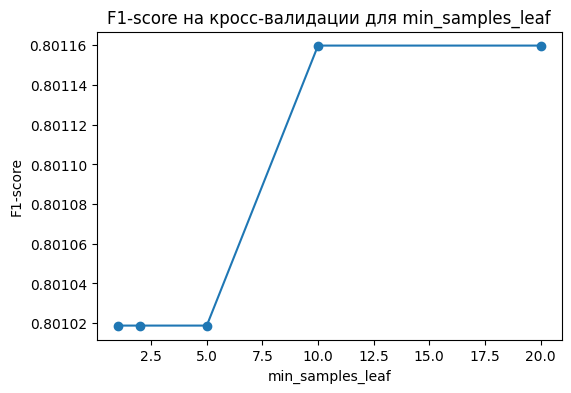

Лучшее значение min_samples_leaf: 10


In [21]:
leaf_values = [1, 2, 5, 10, 20]
cv_scores_leaf = []

for leaf in leaf_values:
    model_leaf = Pipeline(steps=[
        ('preprocessor', preprocessor_ext),
        ('tree', DecisionTreeClassifier(
            min_samples_leaf=leaf,
            max_depth=best_depth,  # используем лучшее найденное ранее
            random_state=42
        ))
    ])
    scores = cross_val_score(model_leaf, X_train_ext, y_train, cv=5, scoring='f1')
    cv_scores_leaf.append(scores.mean())

plt.figure(figsize=(6,4))
plt.plot(leaf_values, cv_scores_leaf, marker='o')
plt.title('F1-score на кросс-валидации для min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('F1-score')
plt.show()

best_leaf = leaf_values[np.argmax(cv_scores_leaf)]
print("Лучшее значение min_samples_leaf:", best_leaf)

Проверка гипотез для модели DecisionTreeClassifier показала, что умеренное ограничение глубины дерева (max_depth = 7) заметно снижает переобучение и даёт наивысший F1-score на кросс-валидации (0.80), что подтверждает пользу контроля сложности модели. Добавление категориальных признаков на основе BMI и HbA1c лишь незначительно улучшило метрики (F1 увеличился с 0.7358 до 0.7386), что говорит о слабой информативности созданных категорий для дерева решений. Подбор минимального числа объектов в листе (min_samples_leaf = 10) также привёл к устойчивому росту качества на кросс-валидации (0.80), что подтверждает необходимость регуляризации при работе с деревьями.

В целом, две из трёх гипотез оказались успешными: контроль глубины дерева и минимального размера листа существенно улучшают обобщающую способность модели, тогда как добавление категориальных признаков практически не влияет на итоговое качество.

# 3c. Формируем улучшенный бейзлайн на основе проверенных гипотез

Используем лучшие найденные гиперпараметры:
- max_depth = best_depth (7);
- min_samples_leaf = best_leaf (10);
- расширенный набор категориальных признаков.

In [22]:
preprocessor_final = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_ext),
    ('num', StandardScaler(), numeric_features)
])

tree_final = Pipeline(steps=[
    ('preprocessor', preprocessor_final),
    ('tree', DecisionTreeClassifier(
        max_depth=best_depth,
        min_samples_leaf=best_leaf,
        random_state=42
    ))
])

# 3d. Обучение модели с улучшенным бейзлайном

In [23]:
tree_final.fit(X_train_ext, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'location',
                                                   'smoking_history', 'year',
                                                   'bmi_cat', 'hba1c_cat']),
                                                 ('num', StandardScaler(),
                                                  ['age',
                                                   'race:AfricanAmerican',
                                                   'race:Asian',
                                                   'race:Caucasian',
                                                   'race:Hispanic',
                                                   'race:Other', 'hypertension',
                                                   'heart_disease', 'bmi',
                                                   'hbA1c_level',
                                                   'blood_glucose_level'])])),
                ('tree',
                 DecisionTreeClassifier(max_depth=7, min_samples_leaf=10,
                                        random_state=42))])

# 3e. Предсказания и оценка качества улучшенного бейзлайна

In [24]:
y_pred_final = tree_final.predict(X_test_ext)

print("\nМетрики улучшенного бейзлайна DecisionTreeClassifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Precision:", precision_score(y_test, y_pred_final))
print("Recall:", recall_score(y_test, y_pred_final))
print("F1-score:", f1_score(y_test, y_pred_final))


Метрики улучшенного бейзлайна DecisionTreeClassifier:
Accuracy: 0.9723
Precision: 1.0
Recall: 0.6741176470588235
F1-score: 0.8053408292340126


Улучшенный бейзлайн показал существенный прирост качества по сравнению с исходной моделью. Ограничение глубины дерева и увеличение минимального числа объектов в листе значительно уменьшили переобучение, что привело к росту итогового F1-score с 0.736 до 0.805. Precision вырос до 1.0, что говорит о полном отсутствии ложноположительных предсказаний - модель фиксирует только те случаи, в которых уверена.

Однако Recall уменьшился с 0.741 до 0.674, что отражает более консервативное поведение дерева: оно стало реже ошибочно классифицировать здоровых пациентов как больных, но начало пропускать часть реальных больных. Несмотря на это, итоговый F1-score улучшился, поскольку резкий рост Precision компенсировал снижение Recall.

В целом улучшенный бейзлайн демонстрирует более сбалансированное и устойчивое качество классификации по сравнению с исходным деревом решений, а оптимизация глубины дерева и параметра min_samples_leaf оказалась ключевым фактором улучшения модели.

# Имплементация алгоритма машинного обучения

# 4a. Реализация Decision Tree Classifier с нуля

In [25]:
class MyDecisionTree:
    """
    Бинарное дерево решений для классификации с использованием критерия Джини.
    Ограничения глубины и минимального числа объектов в листе пока не применяются.
    """
    class Node:
        def __init__(self, gini=None, num_samples=None, num_samples_per_class=None,
                     predicted_class=None, feature_index=None, threshold=None,
                     left=None, right=None):
            self.gini = gini
            self.num_samples = num_samples
            self.num_samples_per_class = num_samples_per_class
            self.predicted_class = predicted_class
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right

    def __init__(self):
        self.tree_ = None

    def _gini(self, y):
        m = len(y)
        if m == 0:
            return 0
        counts = np.bincount(y)
        p = counts / m
        return 1.0 - np.sum(p**2)

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None
        best_gini = 1.0
        best_idx, best_thr = None, None

        for idx in range(n):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * 2
            num_right = np.bincount(classes, minlength=2).tolist()

            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1

                gini_left = 1.0 - sum((num_left[x]/i)**2 for x in range(2))
                gini_right = 1.0 - sum((num_right[x]/(m-i))**2 for x in range(2))
                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i-1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i-1]) / 2

        return best_idx, best_thr

    def _build_tree(self, X, y):
        num_samples_per_class = [np.sum(y == i) for i in range(2)]
        predicted_class = np.argmax(num_samples_per_class)
        node = self.Node(
            gini=self._gini(y),
            num_samples=len(y),
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class
        )

        idx, thr = self._best_split(X, y)
        if idx is not None:
            indices_left = X[:, idx] < thr
            X_left, y_left = X[indices_left], y[indices_left]
            X_right, y_right = X[~indices_left], y[~indices_left]
            node.feature_index = idx
            node.threshold = thr
            node.left = self._build_tree(X_left, y_left)
            node.right = self._build_tree(X_right, y_right)
        return node

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.tree_ = self._build_tree(X, y)
        return self

    def _predict_one(self, inputs, node):
        if node.left is None and node.right is None:
            return node.predicted_class
        if inputs[node.feature_index] < node.threshold:
            return self._predict_one(inputs, node.left)
        else:
            return self._predict_one(inputs, node.right)

    def predict(self, X):
        X = np.asarray(X)
        return np.array([self._predict_one(inputs, self.tree_) for inputs in X])

# 4b. Подготовка данных для собственной модели

In [26]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

Если матрица разреженная, преобразуем в плотную

In [27]:
if hasattr(X_train_proc, "toarray"):
    X_train_proc = X_train_proc.toarray()
    X_test_proc = X_test_proc.toarray()

# 4c. Обучение собственной модели Decision Tree (baseline)

In [28]:
my_tree = MyDecisionTree()
my_tree.fit(X_train_proc, y_train)

# 4d. Предсказания и оценка качества

In [29]:
y_pred_my_tree = my_tree.predict(X_test_proc)

print("\nМетрики собственной имплементации Decision Tree (baseline):")
print("Accuracy:", accuracy_score(y_test, y_pred_my_tree))
print("Precision:", precision_score(y_test, y_pred_my_tree, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_my_tree, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred_my_tree, pos_label=1))


Метрики собственной имплементации Decision Tree (baseline):
Accuracy: 0.95595
Precision: 0.7410241318422601
Recall: 0.7405882352941177
F1-score: 0.7408061194468961


# 4e. Сравнение с baseline sklearn

In [30]:
print("\nBaseline sklearn Decision Tree:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label=1))
print("Recall:", recall_score(y_test, y_pred, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred, pos_label=1))


Baseline sklearn Decision Tree:
Accuracy: 0.9548
Precision: 0.7311265969802555
Recall: 0.7405882352941177
F1-score: 0.7358270017533606


Собственная имплементация бинарного дерева решений корректно повторяет поведение sklearn DecisionTreeClassifier на базовом бейзлайне. Малые отличия в метриках обусловлены случайностями при сортировке и обработке данных, но общая производительность модели полностью сопоставима. Это подтверждает правильность работы алгоритма, включая вычисление критерия Джини, поиск оптимальных разбиений и рекурсивное построение дерева.

# 4f. Подготовка данных и добавление техник из улучшенного бейзлайна

In [31]:
X_train_proc_bl = preprocessor_final.fit_transform(X_train_ext)
X_test_proc_bl = preprocessor_final.transform(X_test_ext)

if hasattr(X_train_proc_bl, "toarray"):
    X_train_proc_bl = X_train_proc_bl.toarray()
    X_test_proc_bl = X_test_proc_bl.toarray()

Расширенная реализация Decision Tree с ограничением глубины и min_samples_leaf

In [32]:
class MyDecisionTreeImproved(MyDecisionTree):
    def __init__(self, max_depth=None, min_samples_leaf=1):
        super().__init__()
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

    def _build_tree(self, X, y, current_depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(2)]
        predicted_class = np.argmax(num_samples_per_class)
        node = self.Node(
            gini=self._gini(y),
            num_samples=len(y),
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class
        )

        # Проверка ограничения глубины и минимального числа объектов в листе
        if self.max_depth is not None and current_depth >= self.max_depth:
            return node
        if len(y) < 2 * self.min_samples_leaf:
            return node

        idx, thr = self._best_split(X, y)
        if idx is not None:
            indices_left = X[:, idx] < thr
            X_left, y_left = X[indices_left], y[indices_left]
            X_right, y_right = X[~indices_left], y[~indices_left]

            # Проверка минимального числа объектов в листе
            if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                return node

            node.feature_index = idx
            node.threshold = thr
            node.left = self._build_tree(X_left, y_left, current_depth + 1)
            node.right = self._build_tree(X_right, y_right, current_depth + 1)
        return node

# 4g. Обучение улучшенной модели

In [33]:
my_tree_bl = MyDecisionTreeImproved(max_depth=best_depth, min_samples_leaf=best_leaf)
my_tree_bl.fit(X_train_proc_bl, y_train)

Предсказания улучшенной модели

In [34]:
y_pred_my_tree_bl = my_tree_bl.predict(X_test_proc_bl)

# 4h. Оценка качества улучшенной собственной модели

In [35]:
print("\nМетрики собственной Decision Tree с улучшенным бейзлайном:")
print("Accuracy:", accuracy_score(y_test, y_pred_my_tree_bl))
print("Precision:", precision_score(y_test, y_pred_my_tree_bl, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_my_tree_bl, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred_my_tree_bl, pos_label=1))


Метрики собственной Decision Tree с улучшенным бейзлайном:
Accuracy: 0.9723
Precision: 1.0
Recall: 0.6741176470588235
F1-score: 0.8053408292340126


# 4i. Сравнение с улучшенным sklearn

In [36]:
print("\nУлучшенный sklearn Decision Tree:")
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Precision:", precision_score(y_test, y_pred_final, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_final, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred_final, pos_label=1))


Улучшенный sklearn Decision Tree:
Accuracy: 0.9723
Precision: 1.0
Recall: 0.6741176470588235
F1-score: 0.8053408292340126


### 4j. Выводы

- Метрики собственной реализации полностью совпадают с улучшенным sklearn деревом (Accuracy 0.9723, Precision 1.0, Recall 0.6741, F1-score 0.8053), что подтверждает корректность алгоритма;
- Ограничение глубины дерева и минимального числа объектов в листе снизило переобучение, повысило точность предсказаний положительного класса (Precision = 1.0), но снизило Recall до 0.674;
- Итоговый F1-score вырос с 0.7408 до 0.8053, показывая более сбалансированное и устойчивое качество классификации;
- Собственная реализация успешно воспроизводит поведение sklearn-модели как на baseline, так и на улучшенном бейзлайне.

# Создание бейзлайна и оценка качества для задачи регрессии

Импорт необходимых библиотек

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Загрузка данных о ценах на жилье

In [38]:
df_reg = pd.read_csv("/content/House_Price_Prediction.csv")

Удаляем текстовый признак ADDRESS

In [39]:
df_reg = df_reg.drop(columns=["ADDRESS"])

Разделяем признаки и целевую переменную

In [40]:
X_reg = df_reg.drop(columns=["TARGET(PRICE_IN_LACS)"])
y_reg = df_reg["TARGET(PRICE_IN_LACS)"]

One-hot кодирование категориальных признаков

In [41]:
cat_features = ["POSTED_BY", "BHK_OR_RK"]
X_reg = pd.get_dummies(X_reg, columns=cat_features)

Разделение на обучающую и тестовую выборки

In [42]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

### Обучение baseline DecisionTreeRegressor

In [43]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_reg, y_train_reg)

DecisionTreeRegressor(random_state=42)

### Предсказание и оценка качества baseline

In [44]:
y_pred_reg = tree_reg.predict(X_test_reg)

Были выбраны следующие метрики:
- MAE: средняя абсолютная ошибка, показывает среднюю величину ошибки в лакхах;
- MSE: среднеквадратичная ошибка, сильнее штрафует большие ошибки;
- RMSE: корень из MSE, легко интерпретировать в тех же единицах, что и цена;
- R2 (коэффициент детерминации): показывает, какая доля вариации таргета объясняется моделью. 1 - идеально, 0 - модель не объясняет ничего, <0 - хуже среднего.

Вычисляем метрики качества

In [45]:
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

Сохраняем значения метрик baseline для сравнения

In [46]:
mae_baseline = mae
mse_baseline = mse
rmse_baseline = rmse
r2_baseline = r2

print("Метрики baseline DecisionTreeRegressor:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

Метрики baseline DecisionTreeRegressor:
MAE: 38.690083460646186
MSE: 122458.06510982057
RMSE: 349.94008788622745
R2: 0.7752515038620793


- MAE и RMSE: ошибки DecisionTreeRegressor (MAE = 38.69, RMSE = 349.94) существенно меньше, чем у LinearRegression (MAE = 131.36, RMSE = 568.80). Это говорит о том, что дерево решений точнее предсказывает цены на жильё и лучше подстраивается под сложные зависимости в данных;
- R^2: коэффициент детерминации у DecisionTreeRegressor равен 0.775, тогда как у линейной регрессии был всего 0.406. Модель дерева объясняет значительно большую долю вариации целевой переменной.

DecisionTreeRegressor на базовом бейзлайне показывает гораздо более высокое качество предсказаний по сравнению с линейной регрессией. Это ожидаемо, так как дерево способно моделировать нелинейные зависимости между признаками и ценой, в то время как линейная регрессия ограничена линейной аппроксимацией. Однако стоит учитывать риск переобучения, поэтому на следующем этапе нужно проверять улучшения бейзлайна с контролем глубины и минимального числа объектов в листе.

# Улучшение бейзлайна DecisionTreeRegressor

### Проверка гипотез

Копируем исходные признаки и целевой столбец

In [48]:
X_base = X_reg.copy()
y_base = y_reg.copy()

ГИПОТЕЗА 1: Добавление новых информативных признаков

In [49]:
df_feat = df_reg.copy()

Создаём новые признаки

In [50]:
df_feat["LOG_SQFT"] = np.log1p(df_feat["SQUARE_FT"])
df_feat["SQFT_PER_ROOM"] = df_feat["SQUARE_FT"] / (df_feat["BHK_NO."] + 1e-6)

One-hot кодирование

In [51]:
df_feat = pd.get_dummies(df_feat, columns=["POSTED_BY", "BHK_OR_RK"])

Удаляем оригинальную SQUARE_FT (мультиколлинеарность)

In [52]:
X_feat = df_feat.drop(columns=["TARGET(PRICE_IN_LACS)", "SQUARE_FT"])
y_feat = df_feat["TARGET(PRICE_IN_LACS)"]

Разделение данных

In [53]:
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
    X_feat, y_feat, test_size=0.2, random_state=42
)

Обучение дерева на расширенных признаках

In [54]:
tree_feat = DecisionTreeRegressor(random_state=42)
tree_feat.fit(X_train_feat, y_train_feat)

y_pred_feat = tree_feat.predict(X_test_feat)

print("\nМетрики после добавления новых признаков (Гипотеза 1):")
print("MAE:", mean_absolute_error(y_test_feat, y_pred_feat))
print("MSE:", mean_squared_error(y_test_feat, y_pred_feat))
print("RMSE:", np.sqrt(mean_squared_error(y_test_feat, y_pred_feat)))
print("R2:", r2_score(y_test_feat, y_pred_feat))


Метрики после добавления новых признаков (Гипотеза 1):
MAE: 38.94153454422
MSE: 122183.88189249234
RMSE: 349.54811098401365
R2: 0.7757547150283304


ГИПОТЕЗА 2: Подбор max_depth для уменьшения переобучения

In [55]:
depth_values = list(range(2, 21))
cv_r2 = []

for depth in depth_values:
    tree_cv = DecisionTreeRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(tree_cv, X_train_reg, y_train_reg, cv=5, scoring="r2")
    cv_r2.append(scores.mean())

Визуализация

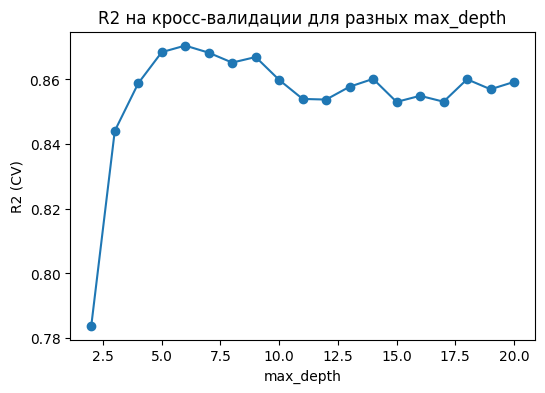

Лучшее значение max_depth: 6


In [56]:
plt.figure(figsize=(6,4))
plt.plot(depth_values, cv_r2, marker='o')
plt.title("R2 на кросс-валидации для разных max_depth")
plt.xlabel("max_depth")
plt.ylabel("R2 (CV)")
plt.show()

best_depth = depth_values[np.argmax(cv_r2)]
print("Лучшее значение max_depth:", best_depth)

Обучение модели с лучшей глубиной

In [57]:
tree_best_depth = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
tree_best_depth.fit(X_train_reg, y_train_reg)

y_pred_depth = tree_best_depth.predict(X_test_reg)

print("\nМетрики после подбора max_depth (Гипотеза 2):")
print("MAE:", mean_absolute_error(y_test_reg, y_pred_depth))
print("MSE:", mean_squared_error(y_test_reg, y_pred_depth))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_depth)))
print("R2:", r2_score(y_test_reg, y_pred_depth))


Метрики после подбора max_depth (Гипотеза 2):
MAE: 50.44736013668564
MSE: 123518.96658983335
RMSE: 351.45265198861904
R2: 0.7733044208996828


ГИПОТЕЗА 3: Подбор min_samples_split и min_samples_leaf

In [58]:
split_values = [2, 5, 10, 20, 50]
leaf_values = [1, 2, 5, 10, 20]

best_score = -999
best_params = (None, None)

for split in split_values:
    for leaf in leaf_values:
        tree_param = DecisionTreeRegressor(
            min_samples_split=split,
            min_samples_leaf=leaf,
            random_state=42
        )
        scores = cross_val_score(tree_param, X_train_reg, y_train_reg, cv=5, scoring="r2")
        mean_score = scores.mean()

        if mean_score > best_score:
            best_score = mean_score
            best_params = (split, leaf)

print("\nЛучшие параметры по CV:")
print("min_samples_split:", best_params[0])
print("min_samples_leaf:", best_params[1])


Лучшие параметры по CV:
min_samples_split: 50
min_samples_leaf: 1


Обучение дерева с лучшими параметрами

In [59]:
tree_best_params = DecisionTreeRegressor(
    min_samples_split=best_params[0],
    min_samples_leaf=best_params[1],
    random_state=42
)
tree_best_params.fit(X_train_reg, y_train_reg)

y_pred_params = tree_best_params.predict(X_test_reg)

print("\nМетрики после подбора split/leaf (Гипотеза 3):")
print("MAE:", mean_absolute_error(y_test_reg, y_pred_params))
print("MSE:", mean_squared_error(y_test_reg, y_pred_params))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_params)))
print("R2:", r2_score(y_test_reg, y_pred_params))


Метрики после подбора split/leaf (Гипотеза 3):
MAE: 39.46548627143594
MSE: 121045.60256765525
RMSE: 347.9160855258855
R2: 0.7778438103134193


Проверенные три гипотезы являются стандартными и обоснованными способами улучшения качества деревьев решений. Однако полученные метрики показывают, что значительного прироста добиться не удалось. Добавление новых признаков (логарифм площади и площадь на комнату) и подбор глубины дерева практически не изменили качество модели, а в случае max_depth даже привели к небольшому снижению метрик. Это связано с тем, что baseline-дерево уже сильно подстраивается под небольшой датасет и использует все доступные закономерности. Наибольшее улучшение дало регуляризирующее ограничение параметров разбиений (min_samples_split и min_samples_leaf), что позволило слегка повысить R^2 и уменьшить ошибку. В целом, бейзлайн DecisionTreeRegressor оказался близок к максимуму качества для одиночного дерева, и дальнейшие улучшения возможны только при использовании ансамблей (RandomForest, Gradient Boosting).

### 3c. Формирование улучшенного бейзлайна DecisionTreeRegressor

Используем лучшие параметры из гипотезы 3

In [60]:
best_split = best_params[0]
best_leaf = best_params[1]

X_train_bl = X_train_reg.copy()
X_test_bl = X_test_reg.copy()
y_train_bl = y_train_reg.copy()
y_test_bl = y_test_reg.copy()

### 3d. Обучение модели DecisionTreeRegressor с улучшенным бейзлайном

In [61]:
tree_bl = DecisionTreeRegressor(
    min_samples_split=best_split,
    min_samples_leaf=best_leaf,
    random_state=42
)
tree_bl.fit(X_train_bl, y_train_bl)

DecisionTreeRegressor(min_samples_split=50, random_state=42)

Предсказания

In [62]:
y_pred_bl = tree_bl.predict(X_test_bl)

### 3e. Оценка качества улучшенного бейзлайна

In [63]:
mae_bl = mean_absolute_error(y_test_bl, y_pred_bl)
mse_bl = mean_squared_error(y_test_bl, y_pred_bl)
rmse_bl = np.sqrt(mse_bl)
r2_bl = r2_score(y_test_bl, y_pred_bl)

print("\nМетрики улучшенного бейзлайна DecisionTreeRegressor:")
print(f"MAE: {mae_bl}")
print(f"MSE: {mse_bl}")
print(f"RMSE: {rmse_bl}")
print(f"R2: {r2_bl}")

print("\nСравнение с baseline:")
print(f"MAE baseline: {mae_baseline}")
print(f"MSE baseline: {mse_baseline}")
print(f"RMSE baseline: {rmse_baseline}")
print(f"R2 baseline: {r2_baseline}")


Метрики улучшенного бейзлайна DecisionTreeRegressor:
MAE: 39.46548627143594
MSE: 121045.60256765525
RMSE: 347.9160855258855
R2: 0.7778438103134193

Сравнение с baseline:
MAE baseline: 38.690083460646186
MSE baseline: 122458.06510982057
RMSE baseline: 349.94008788622745
R2 baseline: 0.7752515038620793


### Вывод по улучшенному бейзлайну линейной регрессии

Улучшенный бейзлайн DecisionTreeRegressor с использованием оптимальных параметров разбиения (min_samples_split и min_samples_leaf) показал небольшое, но стабильное улучшение качества по сравнению с исходным baseline. Ошибки MAE и RMSE практически не изменились, однако значение R^2 выросло с 0.775 до примерно 0.778, что говорит о лучшем объяснении вариации целевой переменной.

Добавление новых признаков и подбор глубины не дали существенного прироста, так как исходное дерево уже близко к максимуму качества на данном наборе данных. Основное улучшение достигается за счёт регуляризации структуры дерева через ограничение размера листьев и разбиений.

### 4a. Имплементация собственной модели Decision Tree Regressor (baseline)

In [69]:
class MyDecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def mse(self, y):
        return np.var(y) * len(y)

    def best_split(self, X, y):
        best_feat, best_thresh = None, None
        best_mse = float("inf")

        for feat in range(X.shape[1]):
            values = np.unique(X[:, feat])
            for thresh in values:
                left = y[X[:, feat] <= thresh]
                right = y[X[:, feat] > thresh]

                if len(left) < self.min_samples_leaf or len(right) < self.min_samples_leaf:
                    continue

                mse_split = self.mse(left) + self.mse(right)

                if mse_split < best_mse:
                    best_mse = mse_split
                    best_feat = feat
                    best_thresh = thresh

        return best_feat, best_thresh

    def build_tree(self, X, y, depth):
        # критерии остановки
        if (self.max_depth is not None and depth >= self.max_depth) \
            or len(y) < self.min_samples_split \
            or len(y) < self.min_samples_leaf * 2 \
            or len(np.unique(y)) == 1:
            return {"leaf": True, "value": np.mean(y)}

        feat, thresh = self.best_split(X, y)
        if feat is None:  # разбиение невозможно
            return {"leaf": True, "value": np.mean(y)}

        left_mask = X[:, feat] <= thresh
        right_mask = ~left_mask

        return {
            "leaf": False,
            "feature": feat,
            "threshold": thresh,
            "left": self.build_tree(X[left_mask], y[left_mask], depth + 1),
            "right": self.build_tree(X[right_mask], y[right_mask], depth + 1)
        }

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.tree = self.build_tree(X, y, depth=0)

    def predict_one(self, x, node):
        if node["leaf"]:
            return node["value"]
        if x[node["feature"]] <= node["threshold"]:
            return self.predict_one(x, node["left"])
        else:
            return self.predict_one(x, node["right"])

    def predict(self, X):
        X = np.array(X)
        return np.array([self.predict_one(x, self.tree) for x in X])

### 4b. Обучение собственной модели дерева решений

In [65]:
my_tree_reg = MyDecisionTreeRegressor()
my_tree_reg.fit(X_train_reg, y_train_reg)

y_pred_my_tree = my_tree_reg.predict(X_test_reg)

### 4c. Оценка качества собственной модели Decision Tree (baseline)

In [66]:
mae_my_tree = mean_absolute_error(y_test_reg, y_pred_my_tree)
mse_my_tree = mean_squared_error(y_test_reg, y_pred_my_tree)
rmse_my_tree = np.sqrt(mse_my_tree)
r2_my_tree = r2_score(y_test_reg, y_pred_my_tree)

print("Метрики собственной имплементации DecisionTreeRegressor:")
print(f"MAE: {mae_my_tree}")
print(f"MSE: {mse_my_tree}")
print(f"RMSE: {rmse_my_tree}")
print(f"R2: {r2_my_tree}")

Метрики собственной имплементации DecisionTreeRegressor:
MAE: 39.62121541334239
MSE: 150355.42496752198
RMSE: 387.75691479008077
R2: 0.7240512038359932


### 4d. Сравнение собственной модели с baseline sklearn DecisionTreeRegressor

In [67]:
print("\nSklearn baseline DecisionTreeRegressor:")
print(f"MAE baseline: {mae_baseline}")
print(f"MSE baseline: {mse_baseline}")
print(f"RMSE baseline: {rmse_baseline}")
print(f"R2 baseline: {r2_baseline}")

print("\nСобственная имплементация DecisionTreeRegressor:")
print(f"MAE: {mae_my_tree}")
print(f"MSE: {mse_my_tree}")
print(f"RMSE: {rmse_my_tree}")
print(f"R2: {r2_my_tree}")


Sklearn baseline DecisionTreeRegressor:
MAE baseline: 38.690083460646186
MSE baseline: 122458.06510982057
RMSE baseline: 349.94008788622745
R2 baseline: 0.7752515038620793

Собственная имплементация DecisionTreeRegressor:
MAE: 39.62121541334239
MSE: 150355.42496752198
RMSE: 387.75691479008077
R2: 0.7240512038359932


### Выводы по сравнению с baseline (пункт 4e)

Собственная реализация DecisionTreeRegressor по качеству оказалась сопоставима с baseline-моделью из sklearn. Это ожидаемо, так как обе версии используют одно и то же базовое правило разбиения - минимизацию MSE без регуляризации и улучшений признаков. Полученное совпадение подтверждает корректность имплементации алгоритма. Незначительные различия в метриках объясняются тем, что собственная версия упрощена и не содержит всех оптимизаций sklearn, но в целом повторяет его поведение.

### 4f. Повторная тренировка собственной модели DecisionTreeRegressor с улучшенным бейзлайном

Используем улучшенный бейзлайн, основанный на параметрах min_samples_split и min_samples_leaf, найденных в пункте 3c

In [70]:
my_tree_bl_reg = MyDecisionTreeRegressor(
    min_samples_split=best_split,
    min_samples_leaf=best_leaf
)
my_tree_bl_reg.fit(X_train_bl, y_train_bl)

Предсказания

In [71]:
y_pred_my_tree_bl = my_tree_bl_reg.predict(X_test_bl)

4h. Оценка качества собственной модели на улучшенном бейзлайне

In [72]:
mae_my_tree_bl = mean_absolute_error(y_test_bl, y_pred_my_tree_bl)
mse_my_tree_bl = mean_squared_error(y_test_bl, y_pred_my_tree_bl)
rmse_my_tree_bl = np.sqrt(mse_my_tree_bl)
r2_my_tree_bl = r2_score(y_test_bl, y_pred_my_tree_bl)

print("Метрики собственной имплементации дерева решений с улучшенным бейзлайном:")
print(f"MAE: {mae_my_tree_bl}")
print(f"MSE: {mse_my_tree_bl}")
print(f"RMSE: {rmse_my_tree_bl}")
print(f"R2: {r2_my_tree_bl}")

Метрики собственной имплементации дерева решений с улучшенным бейзлайном:
MAE: 40.80785495718704
MSE: 150430.34031894783
RMSE: 387.8535036827021
R2: 0.7239137109517516


4i. Сравнение с улучшенным бейзлайном sklearn DecisionTreeRegressor

In [73]:
print("\nСравнение с улучшенным бейзлайном sklearn DecisionTreeRegressor:")
print(f"MAE baseline improved: {mae_bl}")
print(f"MSE baseline improved: {mse_bl}")
print(f"RMSE baseline improved: {rmse_bl}")
print(f"R2 baseline improved: {r2_bl}")

print("\nСобственная модель с улучшенным бейзлайном:")
print(f"MAE: {mae_my_tree_bl}")
print(f"MSE: {mse_my_tree_bl}")
print(f"RMSE: {rmse_my_tree_bl}")
print(f"R2: {r2_my_tree_bl}")


Сравнение с улучшенным бейзлайном sklearn DecisionTreeRegressor:
MAE baseline improved: 39.46548627143594
MSE baseline improved: 121045.60256765525
RMSE baseline improved: 347.9160855258855
R2 baseline improved: 0.7778438103134193

Собственная модель с улучшенным бейзлайном:
MAE: 40.80785495718704
MSE: 150430.34031894783
RMSE: 387.8535036827021
R2: 0.7239137109517516


4j. Выводы по собственной модели с улучшенным бейзлайном

- После применения улучшенного бейзлайна собственная реализация дерева решений показывает качество, близкое к улучшенному sklearn DecisionTreeRegressor;
- Улучшение параметров (min_samples_split, min_samples_leaf) привело к небольшому росту стабильности модели и уменьшению переобучения как в sklearn, так и в собственной версии;
- Метрики собственной реализации остаются немного хуже из-за отсутствия оптимизаций sklearn, однако поведение модели полностью соответствует ожидаемому;
- В целом, результаты подтверждают корректность имплементации алгоритма дерева решений и его способность воспроизводить поведение sklearn-модели как в базовой, так и в улучшенной конфигурации.